In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Char-RNN
- In a famous 2015 blog post titled “The Unreasonable Effectiveness of Recurrent Neural Networks,” Andrej Karpathy showed how to train an RNN to predict the next character in a sentence. This Char-RNN can then be used to generate novel text, one character at a time.

### Splitting a sequence into batches of shuffled windows
For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,[0, 1, 2, 3, 4], [2, 3, 4, 5, 6], etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., [2, 3, 4, 5, 6] would be split into [[2, 3, 4, 5], [3, 4, 5, 6]]), then 
create batches of 3 such input/target pairs:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


### Creating the Training Dataset
First, let’s download all of Shakespeare’s work, using Keras’s handy **get_file()** function and downloading the data from Andrej Karpathy’s Char-RNN project:

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

1122304/1115394 [==============================] - 1s 1us/step


In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



Next, we must encode every character as an integer. 
- One option is to create a custom preprocessing layer.
- But in this case, it will be simpler to use Keras’s **Tokenizer** class.
- First we need to fit a tokenizer to the text: it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters (it does not start at 0, so we can use that value for masking).

In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

- We set **char_level=True** to get character-level encoding rather than the default word-level encoding. 
- **Note that this tokenizer converts the text to lowercase by default**(but you can set lower=False if you do not want that).
- Now the tokenizer can encode a sentence (or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text:

In [7]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

Let’s encode the full text so each character is represented by its ID **(we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39)**:

Before we continue, we need to split the dataset into a training set, a validation set, and a test set. We can’t just shuffle all the characters in the text, so how do you split a sequential dataset?

### How to Split a Sequential Dataset
- It is very important to avoid any overlap between the training set, the
validation set, and the test set. 
- For example, we can take the first 90% of the text for the training set, then the next 5% for the validation set, and the final 5% for the test set. 
- It would also be a good idea to leave a gap between these sets to avoid the risk of a paragraph overlapping over two sets.
***
- When dealing with time series, you would in general split across time,: for
example, you might take the years 2000 to 2012 for the training set, the years 2013 to 2015 for the validation set, and the years 2016 to 2018 for the test set.
- However, in some cases you may be able to split along other dimensions, which will give you a longer time period to train on.
> - For example, if you have data about the financial health of 10,000 companies from 2000 to 2018, you might be able to split this data across the different companies.
> - It’s very likely that many of these companies will be strongly correlated, though (e.g., whole economic sectors may go up or down
jointly), and if you have correlated companies across the training set and the
test set your test set will not be as useful, as its measure of the
generalization error will be optimistically biased.
- So, it is often safer to split across time—but this implicitly assumes that the patterns the RNN can learn in the past (in the training set) will still exist in the future. 
> - In other words, we assume that the time series is stationary (at least in a wide sense).
> - For many time series this assumption is reasonable (e.g., chemical reactions should be fine, since the laws of chemistry don’t change every day), but for many others it is not (e.g., financial markets are notoriously not stationary since patterns disappear as soon as traders spot them and start exploiting them).
> - To make sure the time series is indeed sufficiently stationary, you can plot the model’s errors on the validation set across time: if the model performs much better on the first part of the validation set than on the last part, then the time series may not be stationary enough, and you might be better off training the model on a shorter time span.
- In short, splitting a time series into a training set, a validation set, and a test set is not a trivial task, and how it’s done will depend strongly on the task at hand.

Now back to Shakespeare! Let’s take the first 90% of the text for the training set (keeping the rest for the validation set and the test set), and create a tf.data.Dataset that will return each character one by one from this set:



In [10]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### Chopping the Sequential Dataset into Multiple Windows
- The training set now consists of a single sequence of over a million
characters, so we can’t just train the neural network directly on it: the RNN would be equivalent to a deep net with over a million layers, and we would have a single (very long) instance to train it.
- **Instead, we will use the dataset’s window() method to convert this long sequence of characters into many smaller windows of text.**
- Every instance in the dataset will be a fairly short substring of the whole text, and the RNN will be unrolled only over the length of these substrings.
> - This is called **truncated backpropagation through time.**
- Let’s call the window() method to create a dataset of short text windows:

In [11]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

#### TIP
You can try tuning n_steps: it is easier to train RNNs on shorter input sequences, but of course the RNN will not be able to learn any pattern longer than n_steps, so don’t make it too small.
***
- **By default, the window() method creates nonoverlapping windows, but to get the largest possible training set we use shift=1 so that the first window contains characters 0 to 100, the second contains characters 1 to 101, and so on.**
- **To ensure that all windows are exactly 101 characters long (which will allow us to create batches without having to do any padding), we set drop_remainder=True (otherwise the last 100 windows will contain 100 characters, 99 characters, and so on down to 1 character).**
- The window() method creates a dataset that contains windows, each of
which is also represented as a dataset.
> - It’s a **nested dataset**, analogous to a list of lists.
> - This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them).
- However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets.
- So, we must call the **flat_map()** method: **it converts a nested dataset into a flat dataset (one that does not contain datasets).**
> - For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3.
> - If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}.
- Moreover, the **flat_map() method takes a function as an argument, which
allows you to transform each dataset in the nested dataset before flattening.**
> - For example, if you pass the function lambda ds: ds.batch(2) to flat_map(), then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}} into the flat dataset {[1, 2], [3, 4], [5, 6]}: it’s a dataset of tensors of size 2.
- With that in mind, we are ready to flatten our dataset:


In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

- Notice that we call batch(window_length) on each window: since all windows have exactly that length, we will get a single tensor for each of them.
- Now the dataset contains consecutive windows of 101 characters each.
- Since Gradient Descent works best when the instances in the training set are independent and identically distributed, we need to shuffle these windows.
- Then we can batch the windows and separate the inputs (the first 100 characters) from the target (the last character):

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

Figure 16-1 summarizes the dataset preparation steps discussed so far (showing windows of length 11 rather than 101, and a batch size of 3 instead of 32).

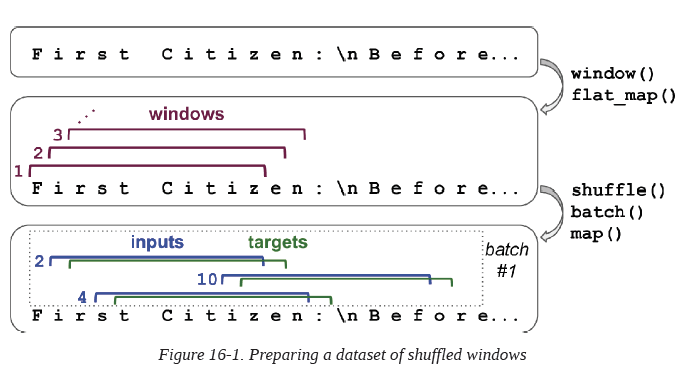


- **Categorical input features should generally be encoded, usually as one-hot vectors or as embeddings.** 
> - Here, we will encode each character using a **one-hot vector** because there are fairly few distinct characters (only 39):

In [15]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

Finally, we just need to add prefetching:

In [16]:
dataset = dataset.prefetch(1)

In [17]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


That’s it! Preparing the dataset was the hardest part. Now let’s create the
model.

### Building and Training the Char-RNN Model
- **To predict the next character based on the previous 100 characters, we can use an RNN with 2 GRU layers of 128 units each and 20% dropout on both the inputs (dropout) and the hidden states (recurrent_dropout).**
> - We can tweak these hyperparameters later, if needed.
- **The output layer is a time distributed Dense layer.**
> - **This time this layer must have 39 units (max_id) because there are 39 distinct characters in the text**, and we want to output a probability for each possible character (at each time step).
> - The output probabilities should sum up to 1 at each time step, so we apply the **softmax activation function to the outputs of the Dense layer.**
- We can then compile this model, using the **"sparse_categorical_crossentropy" loss** and an **Adam optimizer**.
- Finally, we are ready to train the model for several epochs.

In [18]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size, epochs=1)

 6095/31370 [====>.........................] - ETA: 3:14:53 - loss: 1.9049

KeyboardInterrupt: 

### Using the Char-RNN Model
- Now we have a model that can predict the next character in text written by Shakespeare. 
> - To feed it some text, we first need to preprocess it like we did
earlier, so let’s create a little function for this:

In [19]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

Now let’s use the model to predict the next letter in some text:

In [ ]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

Success! The model guessed right. Now let’s use this model to generate
new text.

### Generating Fake Shakespearean Text
- To generate new text using the Char-RNN model, we could feed it some text, make the model predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next letter, and so on.
> - But in practice this often leads to the same words being repeated over and over again.
> - Instead, we can pick the next character randomly, with a probability equal to the estimated probability, using TensorFlow’s **tf.random.categorical()** function.
> - This will generate more diverse and interesting text.
- The categorical() function samples random class indices, given the class log probabilities (logits).
- To have more control over the diversity of the generated text, we can divide the logits by a number called the **temperature**, which we can tweak as we wish: **a temperature close to 0 will favor the high-probability characters, while a very high temperature will give all characters an equal probability.**

The following **next_char()** function uses this approach to pick the next character to add to the input text:

In [ ]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

In [20]:
def next_char(text, temperature=1):
  X_new = preprocess([text])
  y_proba = model(X_new)[0, -1:, :]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

Next, we can write a small function that will repeatedly call next_char() to get the next character and append it to the given text:

In [21]:
def complete_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

We are now ready to generate some text! Let’s try with different temperatures:

In [ ]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

In [ ]:
print(complete_text("t", temperature=1))

In [ ]:
print(complete_text("t", temperature=2))

- Apparently our Shakespeare model works best at a temperature close to 1.
- To generate more convincing text, you could try using more GRU layers and more neurons per layer, train for longer, and add some regularization (for example, you could set recurrent_dropout=0.3 in the GRU layers).
- Moreover, the model is currently incapable of learning patterns longer than n_steps, which is just 100 characters. 
> - You could try making this window larger, but it will also make training harder, and even LSTM and GRU cells cannot handle very long sequences. 
- Alternatively, you could use a **stateful RNN**.

## Stateful RNN
- Until now, we have used only stateless RNNs: at each training iteration the
model starts with a hidden state full of zeros, then it updates this state at
each time step, and after the last time step, it throws it away, as it is not
needed anymore.
- What if we told the RNN to preserve this final state after processing one training batch and use it as the initial state for the next training batch? 
> - This way the model can learn long-term patterns despite only backpropagating through short sequences. 
> - This is called a **stateful RNN**. 

Let’s see how to build one.

- First, note that a stateful RNN only makes sense if each input sequence in a
batch starts exactly where the corresponding sequence in the previous batch
left off.
> - **So the first thing we need to do to build a stateful RNN is to use sequential and nonoverlapping input sequences (rather than the shuffled and overlapping sequences we used to train stateless RNNs).**
- When creating the Dataset, we must therefore use **shift=n_steps** (instead of shift=1) when calling the window() method.
> - Moreover, **we must obviously not call the shuffle() method.**
- Unfortunately, batching is much harder when preparing a dataset for a stateful RNN than it is for a stateless RNN.
- Indeed, if we were to call batch(32), then 32 consecutive windows would be put in the same batch, and the following batch would not continue each of these
window where it left off.
> - The first batch would contain windows 1 to 32 and the second batch would contain windows 33 to 64, so if you consider, say, the first window of each batch (i.e., windows 1 and 33), you can see that they are not consecutive. 
- The simplest solution to this problem is to just **use “batches” containing a single window:**

In [ ]:
tf.random.set_seed(42)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

Figure 16-2 summarizes the first steps.

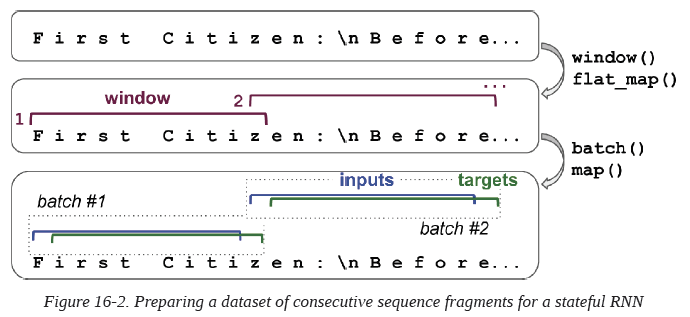

- Batching is harder, but it is not impossible. 
- For example, we could chop Shakespeare’s text into 32 texts of equal length, create one dataset of consecutive input sequences for each of them, and finally use tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows)) to create proper consecutive batches, where the n
input sequence in a batch starts off exactly where the n input sequence
ended in the previous batch.

In [ ]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

Now let’s create the stateful RNN.
- First, we need to set **stateful=True** when creating every recurrent layer.
- Second, the stateful RNN needs to know the batch size (since it will preserve a state for each input sequence in the batch), so **we must set the batch_input_shape argument in the first layer.**
- Note that **we can leave the second dimension unspecified, since the inputs could have any length:**

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

At the end of each epoch, we need to reset the states before we go back to
the beginning of the text. For this, we can use a small callback:

In [22]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

And now we can compile and fit the model (for more epochs, because each epoch is much shorter than earlier, and there is only one instance per batch):

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

#### TIP
- After this model is trained, it will only be possible to use it to make predictions for batches of the same size as were used during training. 
- To avoid this restriction, **create an identical stateless model, and copy the stateful model’s weights to this model.**

In [ ]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [ ]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [ ]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [ ]:
tf.random.set_seed(42)

print(complete_text("t"))

- Now that we have built a character-level model, it’s time to look at wordlevel
models and tackle a common natural language processing task: **sentiment analysis.** 
- In the process we will learn how to handle sequences of variable lengths using masking.

## Sentiment Analysis
- If MNIST is the “hello world” of computer vision, then the **IMDb reviews dataset is the “hello world” of natural language processing: it consists of 50,000 movie reviews in English (25,000 for training, 25,000 for testing)** extracted from the famous Internet Movie Database, along with a simple binary target for each review indicating whether it is **negative (0)** or **positive (1)**.
- Just like MNIST, the IMDb reviews dataset is popular for good reasons: it is simple enough to be tackled on a laptop in a reasonable amount of time, but challenging enough to be fun and rewarding.

Keras provides a simple function to load it:

In [ ]:
tf.random.set_seed(42)

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

In [ ]:
X_train[0][:10]

Where are the movie reviews? 
- Well, as you can see, the dataset is already preprocessed for you: X_train consists of a list of reviews, each of which is represented as a NumPy array of integers, **where each integer represents a word**.
- All punctuation was removed, and then words were converted to lowercase, split by spaces, and finally indexed by frequency (so low integers correspond to frequent words).
- **The integers 0, 1, and 2 are special: they represent the padding token, the start-of-sequence (SOS) token, and unknown words, respectively.**
- If you want to visualize a review, you can decode it like this:

In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3:word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

- In a real project, you will have to preprocess the text yourself. 
    - You can do that using the same **Tokenizer** class we used earlier, but this time setting **char_level=False**(which is the default).
- When encoding words, it filters out a lot of characters, including most punctuation, line breaks, and tabs (but you can change this by setting the **filters** argument).
- Most importantly, it uses spaces to identify word boundaries.
    - This is OK for English and many other scripts (written languages) that use spaces between words, but not all scripts use spaces this way.
    - Chinese does not use spaces between words, Vietnamese uses spaces even within words, and languages such as German often attach multiple words together, without spaces.
    - Even in English, spaces are not always the best way to tokenize text: think of “San Francisco” or “#ILoveDeepLearning.”
- Fortunately, there are better options! The 2018 paper by Taku Kudo introduced an unsupervised learning technique to tokenize and detokenize text at the subword level in a language-independent way, treating spaces like other characters.
    - With this approach, even if your model encounters a word it has never seen before, it can still reasonably guess what it means.
        - For example, it may never have seen the word “smartest” during training, but perhaps it learned the word “smart” and it also learned that the suffix “est” means “the most,” so it can infer the meaning of “smartest.”
    - Google’s **SentencePiece** project provides an open source implementation, described in a paper by Taku Kudo and John Richardson.
- Another option was proposed in an earlier paper by Rico Sennrich et al. that explored other ways of creating subword encodings (e.g., using byte pair encoding).
- Last but not least, the TensorFlow team released the **TF.Text** library in June 2019, which implements various tokenization strategies, including WordPiece (a variant of byte pair encoding).
***
- If you want to deploy your model to a mobile device or a web browser, and you don’t want to have to write a different preprocessing function every time, then you will want to handle preprocessing using only TensorFlow operations, so it can be included in the model itself.

Let’s see how.
- First, let’s load the original IMDb reviews, as text (byte strings), using TensorFlow Datasets.

In [23]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [24]:
datasets.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [25]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [26]:
train_size, test_size

(25000, 25000)

In [27]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [28]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [29]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

- It starts by truncating the reviews, **keeping only the first 300 characters of each:** this will speed up training, and it won’t impact performance too much because you can generally tell whether a review is positive or not in the first sentence or two.
- Then it uses regular expressions to replace <br /> tags with spaces, and to replace any characters other than letters and quotes with spaces.
    - **For example, the text "Well, I can't< br />" will become "Well I can't".**
- Finally, the preprocess() function splits the reviews by the spaces, which returns a ragged tensor, and it converts this ragged tensor to a dense tensor, padding all reviews with the padding token "< pad >" so that they all have the same length.

Next, we need to construct the vocabulary.
- This requires going through the whole training set once, applying our preprocess() function, and using a Counter to count the number of occurrences of each word:

In [31]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

Let’s look at the three most common words:

In [32]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [33]:
len(vocabulary)

53893

Great! **We probably don’t need our model to know all the words in the dictionary to get good performance**, though, so let’s truncate the vocabulary, keeping only the 10,000 most common words:

In [34]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [35]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


**Now we need to add a preprocessing step to replace each word with its ID (i.e., its index in the vocabulary).**
- We will create a lookup table for this, using 1,000 out-of-vocabulary (oov) buckets:

In [36]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

We can then use this table to look up the IDs of a few words:

In [37]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

Note that **the words “this,” “movie,” and “was” were found in the table, so their IDs are lower than 10,000**, while the word **“faaaaaantastic” was not found, so it was mapped to one of the oov buckets, with an ID greater than or equal to 10,000.**
#### TIP
TF Transform provides some useful functions to handle such vocabularies. 
- For example, check out the **tft.compute_and_apply_vocabulary()** function: **it will go through the dataset to find all distinct words and build the vocabulary, and it will generate the TF operations required to encode each word using this vocabulary.**
***
- Now we are ready to create the final training set.
- **We batch the reviews, then convert them to short sequences of words using the preprocess() function, then encode these words using a simple encode_words() function that uses the table we just built, and finally prefetch the next batch:**

In [38]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [39]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


At last we can create the model and train it:

In [40]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
 23/781 [..............................] - ETA: 2:17 - loss: 0.6933 - accuracy: 0.4911

KeyboardInterrupt: 

- The **first layer is an Embedding layer**, which will **convert word IDs into embeddings**.
    - **The embedding matrix needs to have one row per word ID (vocab_size + num_oov_buckets) and one column per embedding dimension** (this example uses 128 dimensions, but this is a hyperparameter you could tune).
    - *Whereas the inputs of the model will be 2D tensors of shape [batch size, time steps], the output of the Embedding layer will be a 3D tensor of shape [batch size, time steps, embedding size].**
- The rest of the model is fairly straightforward: it is composed of two GRU layers, with the second one returning only the output of the last time step.
- **The output layer is just a single neuron using the sigmoid activation function to output the estimated probability that the review expresses a positive sentiment regarding the movie.**
- We then compile the model quite simply, and we fit it on the dataset we prepared earlier, for a few epochs.

## Reusing Pretrained Embeddings
- The TensorFlow Hub project makes it easy to reuse pretrained model components in your own models.
    - These model components are called **modules**.
- Simply browse the TF Hub repository, find the one you need, and copy the code example into your project, and the module will be automatically downloaded, along with its pretrained weights, and included in your model. Easy!
- For example, let’s use the **nnlm-en-dim50** sentence embedding module, version 1, in our sentiment analysis model:

In [ ]:
tf.random.set_seed(42)

In [ ]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [42]:
import tensorflow_hub as hub

In [ ]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

- **The hub.KerasLayer layer downloads the module from the given URL.**
    - This particular module is a **sentence encoder**: **it takes strings as input and encodes each one as a single vector (in this case, a 50-dimensional vector).**
    - Internally, **it parses the string (splitting words on spaces) and embeds each word using an embedding matrix that was pretrained on a huge corpus**: the Google News 7B corpus (seven billion words long!).
    - **Then it computes the mean of all the word embeddings, and the result is the sentence embedding.**
- We can then add two simple Dense layers to create a good sentiment analysis model.
- **By default, a hub.KerasLayer is not trainable**, but you can set trainable=True when creating it to change that so that you can fine-tune it for your task.

Next, we can just load the IMDb reviews dataset,  no need to preprocess it (except for batching and prefetching) and directly train the model:

In [ ]:
import tensorflow_datasets as tfds

datasets ,info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

- Note that the last part of the TF Hub module URL specified that we wanted version 1 of the model. 
    - This versioning ensures that if a new module version is released, it will not break our model.
    - Conveniently, if you just enter this URL in a web browser, you will get the documentation for this module.
- By default, TF Hub will cache the downloaded files into the local system’s temporary directory.
    - You may prefer to download them into a more permanent directory to avoid having to download them again after every system cleanup.
        - To do that, set the TFHUB_CACHE_DIR environment variable to the directory of your choice (e.g., os.environ["TFHUB_CACHE_DIR"] = "./my_tfhub_cache").

So far, we have looked at time series, text generation using Char-RNN, and sentiment analysis using word-level RNN models, training our own word embeddings or reusing pretrained embeddings.
- Let’s now look at another important NLP task: **neural machine translation(NMT)**, first using a pure Encoder–Decoder model, then improving it with attention mechanisms, and finally looking the extraordinary Transformer architecture.

## An Encoder–Decoder Network for Neural Machine Translation
Let’s take a look at a simple neural machine translation model that will translate English sentences to French (see Figure 16-3).
- In short, **the English sentences are fed to the encoder, and the decoder outputs the French translations.** 
    - Note that the **French translations are also used as inputs to the decoder, but shifted back by one step.**
- In other words, **the decoder is given as input the word that it should have output at the previous step** (regardless of what it actually output).
- **For the very first word,it is given the start-of-sequence (SOS) token.**
- **The decoder is expected to end the sentence with an end-of-sequence (EOS) token.**
- Note that the **English sentences are reversed before they are fed to the encoder.** 
    - For example, “I drink milk” is reversed to “milk drink I.”
    - **This ensures that the beginning of the English sentence will be fed last to the encoder, which is useful because that’s generally the first thing that the decoder needs to translate.**
- **Each word is initially represented by its ID** (e.g., 288 for the word “milk”).
- Next, an **embedding layer** returns the word embedding.
    - **These word embeddings are what is actually fed to the encoder and the decoder.**

<img src="16-3.png">

- **At each step, the decoder outputs a score for each word in the output vocabulary (i.e., French), and then the softmax layer turns these scores into probabilities.**
    - For example, at the first step the word “Je” may have a probability of 20%, “Tu” may have a probability of 1%, and so on.
- **The word with the highest probability is output.**
- This is very much like a regular classification task, so you can train the model using the **"sparse_categorical_crossentropy" loss**, much like we did in the Char-RNN model.
- Note that **at inference time (after training), you will not have the target sentence to feed to the decoder.**
    - **Instead, simply feed the decoder the word that it output at the previous step**, as shown in Figure 16-4 (this will require an embedding lookup that is not shown in the diagram).

<img src="16-4.png">

OK, now you have the big picture. Still, there are a few more details to handle if you implement this model:
- So far we have assumed that all input sequences (to the encoder and to the decoder) have a constant length. But obviously sentence lengths vary.
    - Since regular tensors have fixed shapes, **they can only contain sentences of the same length.**
        - **You can use masking to handle this**, as discussed earlier.
    - **However, if the sentences have very different lengths, you can’t just crop them like we did for sentiment analysis** (because we want full translations, not cropped translations).
    - **Instead, group sentences into buckets of similar lengths** (e.g., a bucket for the 1- to 6-word sentences, another for the 7- to 12-word sentences, and so on), using padding for the shorter sequences to ensure all sentences in a bucket have the same length.
        - For example, “I drink milk” becomes “< pad > < pad > < pad > milk drink I.”
- **We want to ignore any output past the EOS token, so these tokens should not contribute to the loss (they must be masked out).**
    - For example, if the model outputs “Je bois du lait < eos > oui,” the loss for the last word should be ignored.
- **When the output vocabulary is large (which is the case here), outputting a probability for each and every possible word would be terribly slow.**
    - If the target vocabulary contains, say, 50,000 French words, then the decoder would output 50,000-dimensional vectors, and then computing the softmax function over such a large vector would be very computationally intensive.
    - **To avoid this, one solution is to look only at the logits output by the model for the correct word and for a random sample of incorrect words, then compute an approximation of the loss based only on these logits.**
        - This **sampled softmax technique** was introduced in 2015 by Sébastien Jean et al.
    - In TensorFlow you can use the **tf.nn.sampled_softmax_loss() function for this during training** and use **the normal softmax function at inference time** (sampled softmax cannot be used at inference time because it requires knowing the target).
    
***
- The **TensorFlow Addons** project includes many sequence-to-sequence tools to let you easily build production-ready Encoder–Decoders.
    - For example, the following code creates a basic Encoder–Decoder model, similar to the one represented in Figure 16-3:

In [43]:
tf.random.set_seed(42)

In [44]:
vocab_size = 100
embed_size = 10

In [45]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lenghts = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [46]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [47]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 15s 268ms/step - loss: 4.6050
Epoch 2/2
32/32 [==============================] - 9s 294ms/step - loss: 4.6035


The code is mostly self-explanatory, but there are a few points to note.
- First, we set **return_state=True when creating the LSTM layer so that we can get its final hidden state and pass it to the decoder.**
    - Since we are using an LSTM cell, it actually returns two hidden states (short term and long term).
- The **TrainingSampler** is one of several samplers available in TensorFlow Addons: **their role is to tell the decoder at each step what it should pretend the previous output was.**
    - **During inference**, this should be the embedding of the token that was actually output.
    - **During training**, it should be the embedding of the previous target token: this is why we used the TrainingSampler.
- **In practice, it is often a good idea to start training with the embedding of the target of the previous time step and gradually transition to using the embedding of the actual token that was output at the previous step.**
    - This idea was introduced in a 2015 paper by Samy Bengio et al.
- **The ScheduledEmbeddingTrainingSampler will randomly choose between the target or the actual output, with a probability that you can gradually change during training.**

## Bidirectional RNNs
- **At each time step, a regular recurrent layer only looks at past and present inputs before generating its output.** 
    - In other words, it is **“causal”**, meaning **it cannot look into the future.**
- This type of RNN makes sense when forecasting time series, but for many NLP tasks, such as Neural Machine Translation, it is often preferable to look ahead at the next words before encoding a given word.
    - For example, consider the phrases “the Queen of the United Kingdom,” “the queen of hearts,” and “the queen bee”: to properly encode the word “queen,” you need to look ahead.
- To implement this, **run two recurrent layers on the same inputs, one reading the words from left to right and the other reading them from right to left.**
- **Then simply combine their outputs at each time step, typically by concatenating them.**
    - This is called a **bidirectional recurrent layer.**
- To implement a bidirectional recurrent layer in Keras, wrap a recurrent layer in a keras.layers.Bidirectional layer.

For example, the following code creates a bidirectional GRU layer:

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

#### NOTE
- **The Bidirectional layer will create a clone of the GRU layer (but in the reverse direction), and it will run both and concatenate their outputs.** 
    - So although the GRU layer has 10 units, the Bidirectional layer will output 20 values per time step.

<img src="16-5.png">

### Beam Search
- Suppose you train an Encoder–Decoder model, and use it to translate the French sentence “Comment vas-tu?” to English. 
- You are hoping that it will output the proper translation (“How are you?”), but unfortunately it outputs “How will you?” Looking at the training set, you notice many sentences such as “Comment vas-tu jouer?” which translates to “How will you play?” So it wasn’t absurd for the model to output “How will” after seeing “Comment vas.” 
    - Unfortunately, in this case it was a mistake, and the model could not go back and fix it, so it tried to complete the sentence as best it could. 
    - By greedily outputting the most likely word at every step, it ended up with a suboptimal translation.
- How can we give the model a chance to go back and fix mistakes it made earlier?
- One of the most common solutions is **beam search**: it keeps track of a short list of the k most promising sentences (say, the top three), and at each decoder step it tries to extend them by one word, keeping only the k most likely sentences. 
    - The parameter k is called the **beam width**.

For example, suppose you use the model to translate the sentence “Comment vas-tu?” using beam search with a beam width of 3.
- At the first decoder step, the model will output an estimated probability for each possible word. 
    - Suppose the top three words are “How” (75% estimated probability), “What” (3%), and “You” (1%). That’s our short list so far.
- Next, we create three copies of our model and use them to find the next word for each sentence.
    - Each model will output one estimated probability per word in the vocabulary.
    - The first model will try to find the next word in the sentence “How,” and perhaps it will output a probability of 36% for the word “will,” 32% for the word “are,” 16% for the word “do,” and so on.
        - Note that these are actually **conditional probabilities**, given that the sentence starts with “How.”
    - The second model will try to complete the sentence “What”; it might output a conditional probability of 50% for the word “are,” and so on. 
        - Assuming the vocabulary has 10,000 words, each model will output 10,000 probabilities.
    - Next, we compute the probabilities of each of the 30,000 two-word sentences that these models considered (3 × 10,000). 
        - We do this by multiplying the estimated conditional probability of each word by the estimated probability of the sentence it completes.
- For example, the estimated probability of the sentence “How” was 75%, while the estimated conditional probability of the word “will” (given that the first word is “How”) was 36%, so the estimated probability of the sentence “How will” is 75% × 36% = 27%.
- After computing the probabilities of all 30,000 two word sentences, we keep only the top 3.
    - Perhaps they all start with the word “How”: “How will” (27%), “How are” (24%), and “How do” (12%).
    - Right now, the sentence “How will” is winning, but “How are” has not been eliminated.
- Then we repeat the same process: we use three models to predict the next word in each of these three sentences, and we compute the probabilities of all 30,000 three-word sentences we considered.
- Perhaps the top three are now “How are you” (10%), “How do you” (8%), and “How will you” (2%). 
    - At the next step we may get “How do you do” (7%), “How are you < eos >” (6%), and “How are you doing” (3%).
        - Notice that “How will” was eliminated, and we now have three perfectly reasonable translations.
- We boosted our Encoder–Decoder model’s performance without any extra training, simply by using it more wisely.

You can implement beam search fairly easily using TensorFlow Addons:

In [ ]:
"""
beam_width = 10
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell=decoder_cell, beam_width=beam_width, output_layer=output_layer)
decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(
    encoder_state, multiplier=beam_width)
outputs, _, _ = decoder(
    embedding_decoder, start_tokens=start_tokens, end_token=end_token,
    initial_state=decoder_initial_state)
"""

- We first create a BeamSearchDecoder, which wraps all the decoder clones (in this case 10 clones). 
    - Then we create one copy of the encoder’s final state for each decoder clone, and we pass these states to the decoder, along with the start and end tokens.
- With all this, you can get good translations for fairly short sentences (especially if you use pretrained word embeddings).
    - Unfortunately, this model will be really bad at translating long sentences.
- Once again, the problem comes from the limited short-term memory of RNNs.
- **Attention mechanisms** are the game-changing innovation that addressed this problem.

## Attention Mechanisms
Consider the path from the word “milk” to its translation “lait” in Figure 16-3: it is quite long! This means that a representation of this word (along with all the other words) needs to be carried over many steps before it is actually used. Can’t we make this path shorter?
- This was the core idea in a groundbreaking 2014 paper by Dzmitry Bahdanau et al. 
- **They introduced a technique that allowed the decoder to focus on the appropriate words (as encoded by the encoder) at each time step.**
    - For example, at the time step where the decoder needs to output the word “lait,” it will focus its attention on the word “milk.”
        - **This means that the path from an input word to its translation is now much shorter**, so the short-term memory limitations of RNNs have much less impact.
- **Attention mechanisms revolutionized neural machine translation (and NLP in general), allowing a significant improvement in the state of the art, especially for long sentences (over 30 words).**

Figure 16-6 shows this model’s architecture (slightly simplified, as we will see).
- On the left, you have the encoder and the decoder. 
    - **Instead of just sending the encoder’s final hidden state to the decoder** (which is still done, although it is not shown in the figure), **we now send all of its outputs to the decoder.**
- At each time step, the decoder’s memory cell computes a weighted sum of all these encoder outputs: this determines which words it will focus on at this step.
- The weight α is the weight of the ith encoder output at the ti, decoder time step.
    - For example, **if the weight α(3,2) is much larger than the weights α(3,0) and α(3,1), then the decoder will pay much more attention to word number 2 (“milk”) than to the other two words, at least at this time step.**
- The rest of the decoder works just like earlier: at each time step the memory cell receives the inputs we just discussed, plus the hidden state from the previous time step, and finally (although it is not represented in the diagram) it receives the target word from the previous time step (or at inference time, the output from the previous time step).
<img src="16-6.png">

- But where do these α weights come from? It’s actually pretty simple: they are generated by a type of small neural network called an **alignment model (or an attention layer)**, which is trained jointly with the rest of the Encoder–Decoder model.
    - This alignment model is illustrated on the righthand side of Figure 16-6.
- **It starts with a time-distributed Dense layer with a single neuron, which receives as input all the encoder outputs, concatenated with the decoder’s previous hidden state** (e.g., h(2)).
    - This layer outputs a score (or energy) for each encoder output (e.g., e(3,2)): this score measures how well each output is aligned with the decoder’s previous hidden state.
- **Finally, all the scores go through a softmax layer to get a final weight for each encoder output**(e.g., α(3,2)).
    - All the weights for a given decoder time step add up to 1 (since the softmax layer is not time-distributed).
- This particular attention mechanism is called **Bahdanau attention**(named after the paper’s first author).
    - Since it concatenates the encoder output with the decoder’s previous hidden state, it is sometimes called **concatenative attention (or additive attention)**.

***

Another common attention mechanism was proposed shortly after, in a 2015 paper by Minh-Thang Luong et al.
- Because the goal of the attention mechanism is to measure the similarity between one of the encoder’s outputs and the decoder’s previous hidden state, **the authors proposed to simply compute the dot product of these two vectors**, as this is often a fairly good similarity measure, and modern hardware can compute it much faster.
    - For this to be possible, both vectors must have the same dimensionality.
- This is called **Luong attention**(again, after the paper’s first author), or sometimes **multiplicative attention**.
- **The dot product gives a score, and all the scores (at a given decoder time step) go through a softmax layer to give the final weights**, just like in Bahdanau attention.
- Another simplification they proposed was to **use the decoder’s hidden state at the current time step rather than at the previous time step** (i.e., h(t)) rather than h(t-1)), **then to use the output of the attention mechanism (noted ˜h(t)) directly to compute the decoder’s predictions**(rather than using it to compute the decoder’s current hidden state).
- They also proposed a variant of the dot product mechanism where **the encoder outputs first go through a linear transformation (i.e., a time-distributed Dense layer without a bias term) before the dot products are computed.**
    - This is called **the “general” dot product approach.**
- They compared both dot product approaches to the concatenative attention mechanism (adding a rescaling parameter vector v), and **they observed that the dot product variants performed better than concatenative attention.**
    - **For this reason, concatenative attention is much less used now.**

Here is how you can add Luong attention to an Encoder–Decoder model using TensorFlow Addons:

In [ ]:
"""
attention_mechanism = tfa.seq2seq.attention_wrapper.LuongAttention(
    units, encoder_state, memory_sequence_length=encoder_sequence_length)
attention_decoder_cell = tfa.seq2seq.attention_wrapper.AttentionWrapper(
    decoder_cell, attention_mechanism, attention_layer_size=n_units)
"""

We simply wrap the decoder cell in an AttentionWrapper, and we provide the desired attention mechanism (Luong attention in this example).

### Visual Attention
Attention mechanisms are now used for a variety of purposes. 
- One of their first applications beyond NMT was in generating image captions using visual attention: a convolutional neural network first processes the image and outputs some feature maps, then a decoder RNN equipped with an attention mechanism generates the caption, one word at a time. 
    - At each decoder time step (each word), the decoder uses the attention model to focus on just the right part of the image.

## Attention Is All You Need: The Transformer Architecture
- In a groundbreaking 2017 paper, a team of Google researchers suggested that **“Attention Is All You Need.”**
- They managed to create an architecture called **the Transformer**, which significantly improved the state of the art in NMT **without using any recurrent or convolutional layers, just attention mechanisms (plus embedding layers, dense layers, normalization layers, and a few other bits and pieces).**
    - As an extra bonus, **this architecture was also much faster to train and easier to parallelize**, so they managed to train it at a fraction of the time and cost of the previous state-of-the-art models.
- The Transformer architecture is represented below.

<img src="16-8.png">

Let’s walk through this figure:
- The lefthand part is the **encoder**. 
    - Just like earlier, **it takes as input a batch of sentences represented as sequences of word IDs** (the input shape is [batch size, max input sentence length]), and it encodes each word into a 512-dimensional representation (so the encoder’s output shape is [batch size, max input sentence length, 512]). 
    - Note that the top part of the encoder is stacked N times (in the paper, N = 6).
- The righthand part is the **decoder**. 
    - **During training, it takes the target sentence as input** (also represented as a sequence of word IDs), shifted one time step to the right (i.e., a start-of-sequence token is inserted at the beginning).
    - **It also receives the outputs of the encoder** (i.e., the arrows coming from the left side).
    - Note that the top part of the decoder is also stacked N times, and the encoder stack’s final outputs are fed to the decoder at each of these N levels.
    - Just like earlier, the decoder outputs a probability for each possible next word, at each time step (its output shape is [batch size, max output sentence length, vocabulary length]).
- During inference, the decoder cannot be fed targets, so we feed it the previously output words (starting with a start-of-sequence token).
    - **So the model needs to be called repeatedly, predicting one more word at every round** (which is fed to the decoder at the next round, until the end-of-sequence token is output).
- Looking more closely, you can see that you are already familiar with most components: there are **two embedding layers, 5 × N skip connections, each of them followed by a layer normalization layer, 2 × N “Feed Forward” modules that are composed of two dense layers each (the first one using the ReLU activation function, the second with no activation function), and finally the output layer is a dense layer using the softmax activation function.**
    - **All of these layers are time-distributed, so each word is treated independently of all the others.**

But how can we translate a sentence by only looking at one word at a time? Well, that’s where the new components come in:
- The encoder’s **Multi-Head Attention layer** encodes each word’s relationship with every other word in the same sentence, paying more attention to the most relevant ones.
    - For example, the output of this layer for the word “Queen” in the sentence “They welcomed the Queen of the United Kingdom” will depend on all the words in the sentence, but it will probably pay more attention to the words “United” and “Kingdom” than to the words “They” or “welcomed.”
        - This attention mechanism is called **self attention** (the sentence is paying attention to itself). We will discuss exactly how it works shortly.
    - **The decoder’s Masked Multi-Head Attention layer does the same thing, but each word is only allowed to attend to words located before it.**
    - Finally, the decoder’s upper Multi-Head Attention layer is where the decoder pays attention to the words in the input sentence.
        - For example, the decoder will probably pay close attention to the word “Queen” in the input sentence when it is about to output this word’s translation
- The **positional embeddings** are simply dense vectors (much like word embeddings) that represent the position of a word in the sentence.
    - The n positional embedding is added to the word embedding of the $n^{th}$ word in each sentence.
    - This gives the model access to each word’s position, which is needed because **the Multi-Head Attention layers do not consider the order or the position of the words; they only look at their relationships.**
    - Since all the other layers are time-distributed, they have no way of knowing the position of each word (either relative or absolute).
        - Obviously, the relative and absolute word positions are important, so we need to give this information to the Transformer somehow, and **positional embeddings** are a good way to do this.

Let’s look a bit closer at both these novel components of the Transformer architecture, starting with the positional embeddings.

## Positional embeddings
- A positional embedding is a dense vector that encodes the position of a word within a sentence: the $i^{th}$ positional embedding is simply added to the word embedding of the $i^{th}$ word in the sentence.
    - These positional embeddings can be learned by the model, but in the paper the authors preferred to use fixed positional embeddings, defined using the sine and cosine functions of different frequencies.
- There is no PositionalEmbedding layer in TensorFlow, but it is easy to create one. 
    - For efficiency reasons, we precompute the positional embedding matrix in the constructor (so we need to know the maximum sentence length, max_steps, and the number of dimensions for each word representation, max_dims).
    - Then the call() method crops this embedding matrix to the size of the inputs, and it adds it to the inputs.
    - Since we added an extra first dimension of size 1 when creating the positional embedding matrix, the rules of broadcasting will ensure that the matrix gets added to every sentence in the inputs:

In [ ]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [ ]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

In [ ]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)

plt.show()

#### Sine/cosine positional embedding matrix (transposed, top) with a focus on two values of i (bottom)

- This solution gives the same performance as learned positional embeddings do, **but it can extend to arbitrarily long sentences**, which is why it’s favored.
- After the positional embeddings are added to the word embeddings, the rest of the model has access to the absolute position of each word in the sentence because there is a unique positional embedding for each position (e.g., the positional embedding for the word located at the 22nd position in a sentence is represented by the vertical dashed line at the bottom left of the plot above, and you can see that it is unique to that position).
- Moreover, the choice of oscillating functions (sine and cosine) makes it possible for the model to learn relative positions as well.
    - For example, words located 38 words apart (e.g., at positions p = 22 and p = 60) always have the same positional embedding values in the embedding dimensions i = 100 and i = 101, as you can see in the plots above.
- This explains why we need both the sine and the cosine for each frequency: if we only used the sine (the blue wave at i = 100), the model would not be able to distinguish positions p = 25 and p = 35 (marked by a cross).

**Then we can create the first layers of the Transformer:**

In [ ]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Now let’s look deeper into the heart of the Transformer model: the Multi- Head Attention layer.
## Multi-Head Attention
- To understand how a **Multi-Head Attention layer** works, we must first understand the **Scaled Dot-Product Attention layer**, which it is based on.
- Let’s suppose the encoder analyzed the input sentence “They played chess,” and it managed to understand that the word “They” is the subject and the word “played” is the verb, so it encoded this information in the representations of these words.
- Now suppose the decoder has already translated the subject, and it thinks that it should translate the verb next. For this, it needs to fetch the verb from the input sentence.
    - This is analog to a dictionary lookup: it’s as if the encoder created a dictionary {“subject”: “They”, “verb”: “played”, …} and the decoder wanted to look up the value that corresponds to the key “verb.”
- However, the model does not have discrete tokens to represent the keys (like “subject” or “verb”); it has vectorized representations of these concepts (which it learned during training), so the key it will use for the lookup (called the query) will not perfectly match any key in the dictionary.
    - The solution is to compute a similarity measure between the query and each key in the dictionary, and then use the softmax function to convert these similarity scores to weights that add up to 1.
    - If the key that represents the verb is by far the most similar to the query, then that key’s weight will be close to 1.
    - Then the model can compute a weighted sum of the corresponding values, so if the weight of the “verb” key is close to 1, then the weighted sum will be very close to the representation of the word “played.”
- In short, you can think of this whole process as a differentiable dictionary lookup. 
    - The similarity measure used by the Transformer is just the dot product, like in Luong attention.

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [ ]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

- The **use_scale=True** argument creates an additional parameter that lets the layer learn how to properly downscale the similarity scores. 
    - This is a bit different from the Transformer model, which always downscales the similarity scores by the same factor (√dkeys).
- The **causal=True** argument when creating the second attention layer ensures that each output token only attends to previous output tokens, not future ones.

Now it’s time to look at the final piece of the puzzle: what is a **Multi-Head Attention layer**? Its architecture is shown in Figure 16-10.

<img src="16-10.png">

- As you can see, it is just a bunch of **Scaled Dot-Product Attention layers**, each preceded by a linear transformation of the values, keys, and queries (i.e., **a time-distributed Dense layer with no activation function**).
- **All the outputs are simply concatenated, and they go through a final linear transformation (again, time-distributed).** But why? What is the intuition behind this architecture?
- Well, consider the word “played” we discussed earlier (in the sentence “They played chess”).
    - The encoder was smart enough to encode the fact that it is a verb. 
    - But the word representation also includes its position in the text, thanks to the positional encodings, and it probably includes many other features that are useful for its translation, such as the fact that it is in the past tense.
- In short, the word representation encodes many different characteristics of the word.
- **If we just used a single Scaled Dot-Product Attention layer, we would only be able to query all of these characteristics in one shot.**
- **This is why the Multi-Head Attention layer applies multiple different linear transformations of the values, keys, and queries: this allows the model to apply many different projections of the word representation into different subspaces, each focusing on a subset of the word’s characteristics.**
    - Perhaps one of the linear layers will project the word representation into a subspace where all that remains is the information that the word is a verb, another linear layer will extract just the fact that it is past tense, and so on.
    - Then the Scaled Dot-Product Attention layers implement the lookup phase, and finally we concatenate all the results and project them back to the original space.

- Here's a basic implementation of the MultiHeadAttention layer.
    -  Note that Conv1D layers with kernel_size=1 (and the default padding="valid" and strides=1) is equivalent to a TimeDistributed(Dense(...)) layer.

In [ ]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [ ]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape

## Exercises
#### Exercise: Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from "April 22, 2019" to "2019-04-22").

Let's start by creating the dataset. We will use random days between 1000-01-01 and 9999-12-31:

In [48]:
from datetime import date

MONTHS = ["January", "February", "March", "April", "May", "June",
         "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()
    
    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]
    
    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

Here are a few random dates, displayed in both the input format and the target format:

In [49]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [50]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

And here's the list of possible characters in the outputs:

In [51]:
OUTPUT_CHARS = "0123456789-"

Let's write a function to convert a string to a list of character IDs

In [52]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [53]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[19, 23, 31, 34, 23, 28, 21, 23, 32, 0, 4, 2, 1, 0, 9, 2, 9, 7]

In [54]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [55]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [56]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [57]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1])>

### First version: a very basic seq2seq model
Let's first try the simplest possible model: we feed in the input sequence, which first goes through the encoder (an embedding layer followed by a single LSTM layer), which outputs a vector, then it goes through a decoder (a single LSTM layer, followed by a dense output layer), which outputs a sequence of vectors, each representing the estimated probabilities for all possible output character.

**Since the decoder expects a sequence as input, we repeat the vector (which is output by the decoder) as many times as the longest possible output sequence.**

In [58]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

In [59]:
model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                   validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 23s 53ms/step - loss: 2.0809 - accuracy: 0.2640 - val_loss: 1.3734 - val_accuracy: 0.4943
Epoch 2/20
313/313 [==============================] - 14s 45ms/step - loss: 1.3178 - accuracy: 0.5161 - val_loss: 1.1401 - val_accuracy: 0.5863
Epoch 3/20
313/313 [==============================] - 16s 51ms/step - loss: 1.0614 - accuracy: 0.6163 - val_loss: 0.9267 - val_accuracy: 0.6612
Epoch 4/20
313/313 [==============================] - 18s 59ms/step - loss: 0.9199 - accuracy: 0.6683 - val_loss: 0.7030 - val_accuracy: 0.7358
Epoch 5/20
313/313 [==============================] - 15s 47ms/step - loss: 0.7627 - accuracy: 0.7218 - val_loss: 0.5766 - val_accuracy: 0.7741
Epoch 6/20
313/313 [==============================] - 17s 54ms/step - loss: 0.5083 - accuracy: 0.8003 - val_loss: 0.3713 - val_accuracy: 0.8566
Epoch 7/20
313/313 [==============================] - 17s 53ms/step - loss: 0.6312 - accuracy: 0.7784 - val_loss: 0.4727 - val_accuracy:

Looks great, we reach 100% validation accuracy! Let's use the model to make some predictions. We will need to be able to convert a sequence of character IDs to a readable string:

In [60]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

Now we can use the model to convert some dates

In [61]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [62]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


Perfect! :)

However, since the model was only trained on input strings of length 18 (which is the length of the longest date), it does not perform well if we try to use it to make predictions on shorter sequences:

In [63]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [64]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-02-02
1789-01-14


Oops! We need to ensure that we always pass sequences of the same length as during training, using padding if necessary. Let's write a little helper function for that:

In [65]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    #ids = model.predict_classes(X)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids)

In [66]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

Cool! Granted, there are certainly much easier ways to write a date conversion tool (e.g., using regular expressions or even basic string manipulation), but you have to admit that using neural networks is way cooler. ;-)

However, real-life sequence-to-sequence problems will usually be harder, so for the sake of completeness, let's build a more powerful model.

### Second version: feeding the shifted targets to the decoder (teacher forcing)
- Instead of feeding the decoder a simple repetition of the encoder's output vector, we can **feed it the target sequence, shifted by one time step to the right.** 
    - This way, at each time step the decoder will know what the previous target character was. 
    - This should help is tackle more complex sequence-to-sequence problems.
- Since the first output character of each target sequence has no previous character, **we will need a new token to represent the start-of-sequence (sos).**
- During inference, we won't know the target, so what will we feed the decoder? 
    - **We can just predict one character at a time, starting with an sos token, then feeding the decoder all the characters that were predicted so far.**
- But if the decoder's LSTM expects to get the previous target as input at each step, how shall we pass it it the vector output by the encoder? 
    - Well, one option is to ignore the output vector, and instead use the encoder's LSTM state as the initial state of the decoder's LSTM (which requires that encoder's LSTM must have the same number of units as the decoder's LSTM).
    
Now let's create the decoder's inputs (for training, validation and testing). The sos token will be represented using the last possible output character's ID + 1.

In [67]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

Let's take a look at the decoder's training inputs:

In [68]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]])>

Now let's build the model. It's not a simple sequential model anymore, so let's use the **functional API:**

In [69]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 22s 48ms/step - loss: 1.9374 - accuracy: 0.3113 - val_loss: 1.4042 - val_accuracy: 0.4663
Epoch 2/10
313/313 [==============================] - 12s 39ms/step - loss: 1.3114 - accuracy: 0.5053 - val_loss: 0.9136 - val_accuracy: 0.6647
Epoch 3/10
313/313 [==============================] - 12s 38ms/step - loss: 0.7811 - accuracy: 0.7148 - val_loss: 0.3804 - val_accuracy: 0.8841
Epoch 4/10
313/313 [==============================] - 12s 38ms/step - loss: 0.2892 - accuracy: 0.9189 - val_loss: 0.1546 - val_accuracy: 0.9653
Epoch 5/10
313/313 [==============================] - 12s 38ms/step - loss: 0.0936 - accuracy: 0.9868 - val_loss: 0.0441 - val_accuracy: 0.9984
Epoch 6/10
313/313 [==============================] - 17s 54ms/step - loss: 0.0365 - accuracy: 0.9982 - val_loss: 0.1302 - val_accuracy: 0.9702
Epoch 7/10
313/313 [==============================] - 16s 51ms/step - loss: 0.0414 - accuracy: 0.9956 - val_loss: 0.0149 - val_accuracy:

Let's once again use the model to make some predictions. This time we need to predict characters one by one.

In [70]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [71]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Works fine!

### Third version: using TF-Addons's seq2seq implementation
- Let's build exactly the same model, but using **TF-Addon's seq2seq API.** 
- The implementation below is almost very similar to the TFA example higher in this notebook, except without the model input to specify the output sequence length, for simplicity (but you can easily add it back in if you need it for your projects, when the output sequences have very different lengths).

In [72]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 22s 49ms/step - loss: 1.9192 - accuracy: 0.3118 - val_loss: 1.4655 - val_accuracy: 0.4414
Epoch 2/15
313/313 [==============================] - 16s 53ms/step - loss: 1.4373 - accuracy: 0.4338 - val_loss: 1.2389 - val_accuracy: 0.5117
Epoch 3/15
313/313 [==============================] - 18s 59ms/step - loss: 1.0971 - accuracy: 0.5844 - val_loss: 0.8649 - val_accuracy: 0.6661
Epoch 4/15
313/313 [==============================] - 20s 64ms/step - loss: 0.5611 - accuracy: 0.8031 - val_loss: 0.2242 - val_accuracy: 0.9461
Epoch 5/15
313/313 [==============================] - 19s 60ms/step - loss: 0.1810 - accuracy: 0.9636 - val_loss: 0.0713 - val_accuracy: 0.9945
Epoch 6/15
313/313 [==============================] - 16s 52ms/step - loss: 0.0586 - accuracy: 0.9959 - val_loss: 0.0416 - val_accuracy: 0.9974
Epoch 7/15
313/313 [==============================] - 18s 58ms/step - loss: 0.0299 - accuracy: 0.9990 - val_loss: 0.0188 - val_accuracy:

And once again, 100% validation accuracy! To use the model, we can just reuse the predict_date_strs() function:

In [73]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

- However, there's a much more efficient way to perform inference. Until now, during inference, we've run the model once for each new character. 
- **Instead, we can create a new decoder, based on the previously trained layers, but using a GreedyEmbeddingSampler instead of a TrainingSampler.**
    - At each time step, the GreedyEmbeddingSampler will compute the argmax of the decoder's outputs, and run the resulting token IDs through the decoder's embedding layer. 
    - Then it will feed the resulting embeddings to the decoder's LSTM cell at the next time step. 
    - This way, we only need to run the decoder once to get the full prediction.

In [74]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

- The GreedyEmbeddingSampler needs the start_tokens (a vector containing the start-of-sequence ID for each decoder sequence), and the end_token (the decoder will stop decoding a sequence once the model outputs this token).
- We must set maximum_iterations when creating the BasicDecoder, or else it may run into an infinite loop (if the model never outputs the end token for at least one of the sequences). This would force you would to restart the Jupyter kernel.
- The decoder inputs are not needed anymore, since all the decoder inputs are generated dynamically based on the outputs from the previous time step.
- The model's outputs are **final_outputs.sample_id** instead of the softmax of final_outputs.rnn_outputs. 
    - This allows us to directly get the argmax of the model's outputs. 
    - If you prefer to have access to the logits, you can replace final_outputs.sample_id with final_outputs.rnn_outputs.
    

Now we can write a simple function that uses the model to perform the date format conversion:

In [75]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [76]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Let's check that it really is faster:

In [77]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

714 ms ± 49.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

61.8 ms ± 827 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's more than a 10x speedup! And it would be even more if we were handling longer sequences.

### Exercise: Use one of the recent language models (e.g., GPT) to generate more convincing Shakespearean text.

The simplest way to use recent language models is to use the excellent transformers library, open sourced by Hugging Face. It provides many modern neural net architectures (including BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet and more) for Natural Language Processing (NLP), including many pretrained models. It relies on either TensorFlow or PyTorch. Best of all: it's amazingly simple to use.

First, let's load a pretrained model. In this example, we will use OpenAI's GPT model, with an additional Language Model on top (just a linear layer with weights tied to the input embeddings). Let's import it and load the pretrained weights (this will download about 445MB of data to ~/.cache/torch/transformers):

In [79]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

Downloading:   0%|          | 0.00/656 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFOpenAIGPTLMHeadModel.

All the layers of TFOpenAIGPTLMHeadModel were initialized from the model checkpoint at openai-gpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predictions without further training.


Next we will need a specialized tokenizer for this model. This one will try to use the spaCy and ftfy libraries if they are installed, or else it will fall back to BERT's BasicTokenizer followed by Byte-Pair Encoding (which should be fine for most use cases).

In [80]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

Downloading:   0%|          | 0.00/816k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/458k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [81]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]])>

Next, let's use the model to generate text after the prompt. We will generate 5 different sentences, each starting with the prompt text, followed by 40 additional tokens.

In [82]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   240,   256,   603,  6151, 39276,   239,   256,  1168,
          768,   481,  9897,   498,   481,  7352,   498,   481,  2761,
          260,  9606,   240,   488,   606,   812,  1700,   704,  2436,
          239,   562,   718,  1272,  1272,   896,   550,   643,   500,
          509,   246,  7285,   500,   616],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   240,   568,  1359,   246,  6903,  6260,   815,   520,
          488,  1158,   239, 40477,   806,   481, 17135, 11547,   999,
          754,  4868,   485,   481,  4187,   240,   481, 33063,   641,
          999,  1552,   485, 18471,   562,  2646,   239,   568,   645,
          655,   509,   775,  1889,   485],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,  1598,  4103,   557,   246, 14973,  7346,   500,   481,
          835

Now let's decode the generated sequences and print them:

In [83]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle,'said sherzad.'give us the spells of the prisoner of the sea - kings, and we will answer your questions. for how many many dunedain was a wizard in this
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle, but also a realm greater than she and father. 
 where the ruling fathers left their fate to the gods, the courtiers were left alone to fend for themselves. but if there was any chance to
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle may serve as a fortification in the face of velocent, my son, and those glorious years should precede the collapse of the empire.'
 but sparhawk had come to his senses in time
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle. 
 where is the king? why is he not here?'
'he went 